In [1]:
## Copy from https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')
SEED = 42

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data]).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')
df_all   = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name  = 'Test Set'
df_all.name   = 'All Set'
dfs           = [df_train, df_test]

In [3]:
print("The nums of training data is:{}".format(df_train.shape[0]))
print("The nums of predicting data is:{}".format(df_test.shape[0]))
print("Training X shape is:{}".format(df_train.shape))
print("Training y shape is:{}".format(df_train['Survived'].shape))  #shape[0] = 取第个1维度
print("Predicting X shape is:{}".format(df_test.shape))
print("Predicting y shape is:{}".format(df_test.shape[0]))

print('All_data shape is:{}'.format(df_all.shape))
df_train.columns,df_test.columns

The nums of training data is:891
The nums of predicting data is:418
Training X shape is:(891, 12)
Training y shape is:(891,)
Predicting X shape is:(418, 11)
Predicting y shape is:418
All_data shape is:(1309, 12)


(Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
        'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'))

In [4]:
### Sibsp =>> 表示的是自己的兄弟姐妹+配偶的数量
### Parch =>> 表示的是自己的父母和子女的数量
### Pclass ==>> 表示的是乘客的类别Passenger Class - 表示出乘客的社会地位 Have 3 categories: Upper/Middle/Lower
### Embarked ==>> 表示的乘车上船的地点码头 - Have 3 categories: C = Cherbourg/ Q= Queenstown/S = Southampton

In [5]:
df_train.info()  #Age/Cabin/Embarked missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
df_test.info() #Age/Fare/Cabin/Embarked missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
## missing values
df_train.isnull().sum() ## Age/Embarked/Fare missing values canbe filled by statistic values, not Cabin as missing too much
# data, that can't do same with these 3 variables 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [9]:
### Age q缺失值的填充
df_all_corr = df_all.corr().abs().unstack().sort_values(kind = 'quicksort',ascending= False).reset_index()

In [10]:
df_all_corr.rename(columns = {'level_0':'Feature1','level_1':'Feature2',0:'Correction Coefficient'},inplace = True)
df_all_corr[df_all_corr['Feature1'] == 'Age'] ### 年龄跟Pclass是相关的[0.408106]，所以对于缺失的AGe值要考虑特定的Pclass背景

,Feature1,Feature2,Correction Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [11]:
### 
df_all.groupby(['Pclass','Sex']).median()

Age      Fare  Parch  PassengerId  SibSp  Survived
Pclass Sex                                                        
1      female  36.0  80.92915      0          710      0       1.0
       male    42.0  49.50420      0          648      0       0.0
2      female  28.0  23.00000      0          589      0       1.0
       male    29.5  13.00000      0          715      0       0.0
3      female  22.0  10.48960      0          637      0       0.5
       male    25.0   7.89580      0          649      0       0.0

In [12]:
age_by_pclass_sex = df_all.groupby(['Pclass','Sex']).median()['Age']
age_by_pclass_sex

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

In [13]:
### 取pclass sex中的Age中median - 中位数来填充缺失的Age
print("全部样本中Age的中位数是:{}".format(df_all['Age'].median()))
### 取上面分类后每个列别的中位数填充每个类别缺失的数据
df_all['Age'] = df_all.groupby(['Pclass','Sex'])['Age'].apply(lambda x:x.fillna(x.median()))

全部样本中Age的中位数是:28.0


In [14]:
### 缺失的数据中 显示: 相同的票名字和相同的票价和相同的性别和相同的Pclass
df_all[df_all['Embarked'].isnull()] 

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [15]:
### Fill "S" in null of Embarked 
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [16]:
df_all[df_all['Fare'].isnull()] # 60岁没有家庭没有子女的third class d的男性 - 不是单身狗就是流浪汉

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [17]:
median_age = df_all.groupby(['Pclass','Parch','SibSp'])['Fare'].median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(median_age)

In [18]:
###  新建 Desk 特征， 这边表示的是乘客的所在位置->也会对幸存产生影响 -> 
df_all["Desk"] = df_all['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else "M")  # M means Missing 

In [19]:
df_all_decks = df_all.groupby(['Desk', 'Pclass']).count().drop(['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                'Fare', 'Embarked', 'Cabin', 
                                                                'PassengerId', 'Ticket'],axis=1).rename(columns={'Name': 'Count'}).transpose()
df_all_decks[:4]

Desk     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

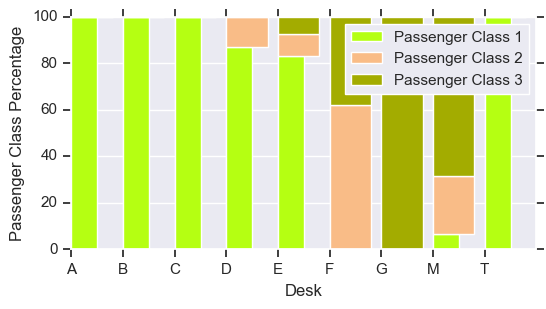

In [20]:
def get_Desk_dist(df):
    desk_dict = {'A':{},'B':{},'C':{},'D':{},'E':{},'F':{},'G':{},'M':{},'T':{}}  
    desks = df.columns.levels[0]  # A,B,C,D....
    for desk in desks:
        for pclass in range(1,4):
            try:
                desk_dict[desk][pclass] = df[desk][pclass][0]
            except KeyError:
                desk_dict[desk][pclass] = 0
                
    desk_df = pd.DataFrame(desk_dict)
    desk_percentage = {}
    for column in desk_df.columns:
        desk_percentage[column] = [100*(count/desk_df[column].sum()) for count in desk_df[column]]
    return desk_dict,desk_percentage

def display_pclass_dist(percentage):
    percentage_df = pd.DataFrame(percentage).transpose()
    desk_names    = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_counts   = np.arange(len(desk_names)) # array 
    pclass1 = percentage_df[0]
    pclass2 = percentage_df[1]
    pclass3 = percentage_df[2]
    bar_width = 0.5
    plt.figure(figsize =(6,3))
    plt.bar(bar_counts,pclass1,color='#b5ff12', edgecolor='white',width = bar_width,label='Passenger Class 1')
    plt.bar(bar_counts,pclass2,color='#f9bc87', edgecolor='white',bottom = pclass1,label='Passenger Class 2')
    plt.bar(bar_counts,pclass3,color='#a3ac00', edgecolor='white',bottom = pclass1 + pclass2,label='Passenger Class 3')
    plt.xlabel('Desk')
    plt.ylabel('Passenger Class Percentage')
    plt.xticks(bar_counts,desk_names) #bar nums , desk_names
    plt.tick_params(axis = 'x')
    plt.tick_params(axis = 'y')
    plt.legend()
    plt.show()
    
desk_dict,desk_percentage = get_Desk_dist(df_all_decks)
display_pclass_dist(desk_percentage)

从上面的图中可以看出:
* 100% of A, B and C decks are 1st class passengers.
* Deck D has 87% 1st class and 13% 2nd class passengers.
* Deck E has 83% 1st class, 10% 2nd class and 7% 3rd class passengers.
* Deck F has 62% 2nd class and 38% 3rd class passengers.
* 100% of G deck are 3rd class passengers.
* There is one person on the boat deck in the T cabin and he is a 1st class passenger. T cabin passenger has the closestresemblance to A deck passengers, so he is grouped in A deck.
* Passengers labeled as M are the missing values in the Cabin feature. I don't think it is possible to find those passengers' * real Deck. I decided to use M like a deck itself.

In [21]:
idx = df_all[df_all['Desk'] == 'T'].index
df_all.loc[idx,'Desk'] = 'A'

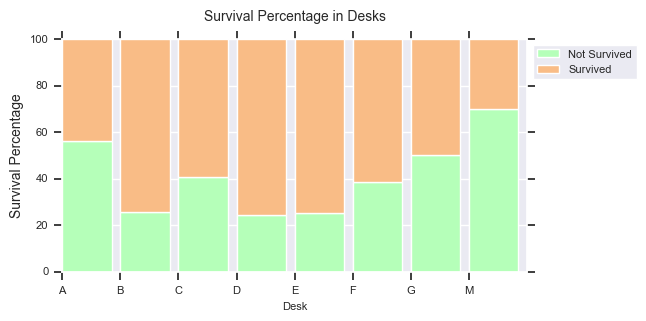

In [22]:
df_all_decks_survived = df_all.groupby(['Desk', 'Survived']).count().drop(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket'],axis=1).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(6, 3))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Desk', size=8, labelpad=4)
    plt.ylabel('Survival Percentage', size=10, labelpad=4)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8})
    plt.title('Survival Percentage in Desks', size=10, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

A, B and C decks are labeled as ABC because all of them have only 1st class passengers.
D and E decks are labeled as DE because both of them have similar passenger class distribution and same survival rate.
F and G decks are labeled as FG because of the previous reasons.
M deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [23]:
df_all["Desk"] = df_all["Desk"].replace(['A','B','C'],'ABC')
df_all["Desk"] = df_all["Desk"].replace(['D','E'],'DE')
df_all["Desk"] = df_all["Desk"].replace(['F','G'],'FG')
df_all["Desk"].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Desk, dtype: int64

In [24]:
##Drop Cabin
df_all.drop('Cabin',axis=1,inplace=True)
df_train,df_test = divide_df(df_all)
dfs              = [df_train,df_test]

In [25]:
###Survived Rate 
not_survived = df_train['Survived'].value_counts()[0]
is_survived = df_train['Survived'].value_counts()[1]
print("Survived rate is:{0:.2f}%".format(100*(is_survived/df_train.shape[0])))
print("Not Survived rate is:{0:.2f}%".format(100*(not_survived/df_train.shape[0])))

Survived rate is:38.38%
Not Survived rate is:61.62%


Features are highly correlated with each other and dependent to each other.
The highest correlation between features is 0.549500 in training set and 0.577147 in test set (between Fare and Pclass).
The other features are also highly correlated. There are 9 correlations in training set and 6 correlations in test set that are higher than 0.1.

In [26]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [27]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [28]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172032


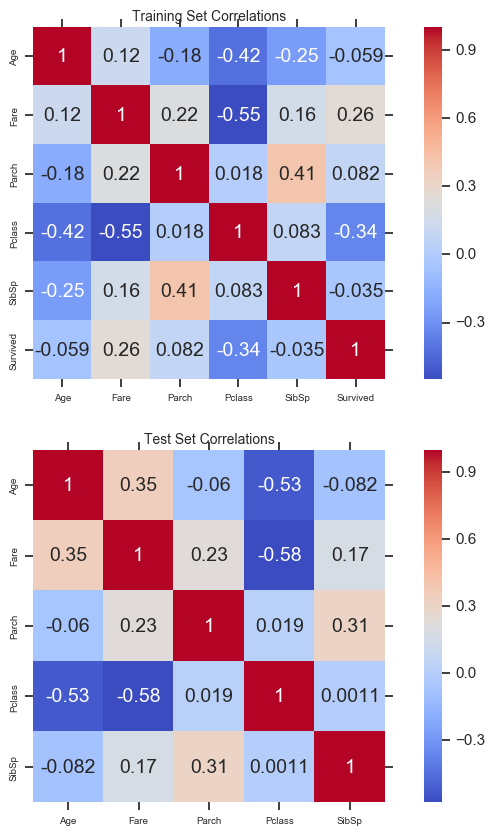

In [29]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=7)
    axs[i].tick_params(axis='y', labelsize=7)
axs[0].set_title('Training Set Correlations', size=10)
axs[1].set_title('Test Set Correlations', size=10)
plt.show()

Both of the continuous features, Age and Fare, have good split points and spikes for a decision tree algorithm to learn.
Distribution of Age feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups.
In the distribution of Fare feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extreme outliers.
One potential problem for both features is, the distribution has more spikes are bumps in training set, but it is smoother in test set. The machine learning algorithm may not able to generalize to test set because of this reason.

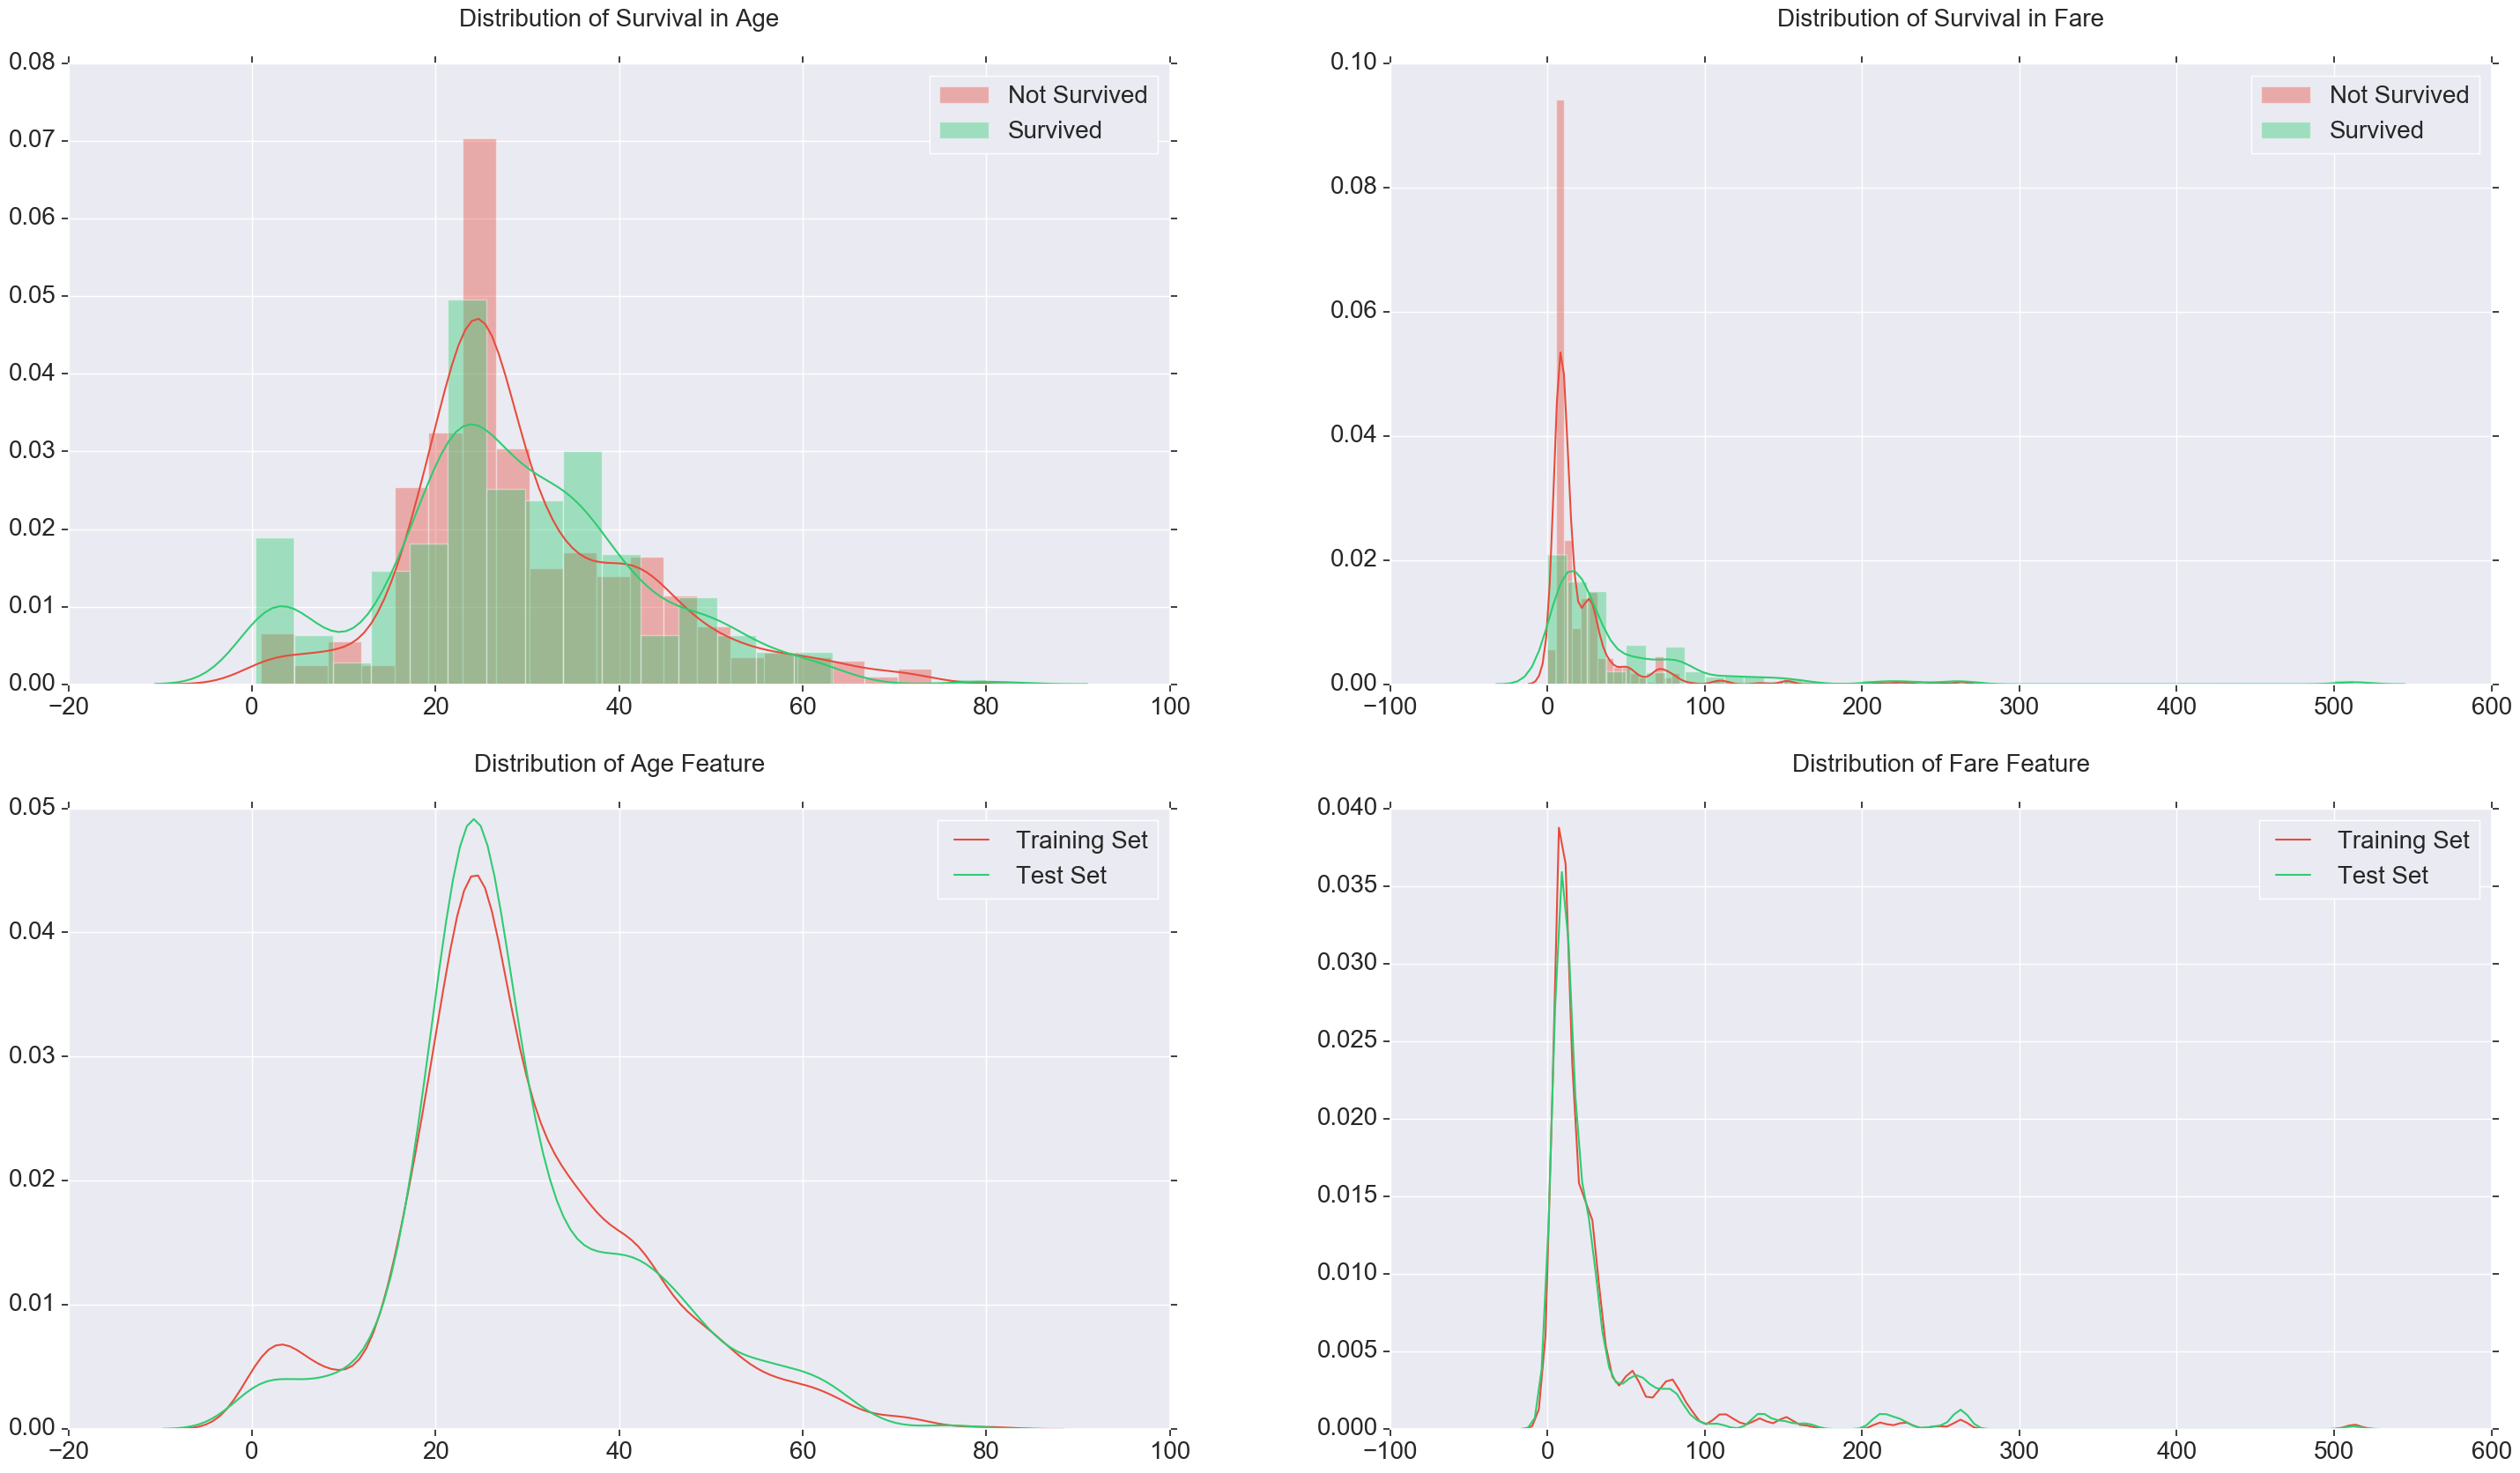

In [30]:
### Continue Features 
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

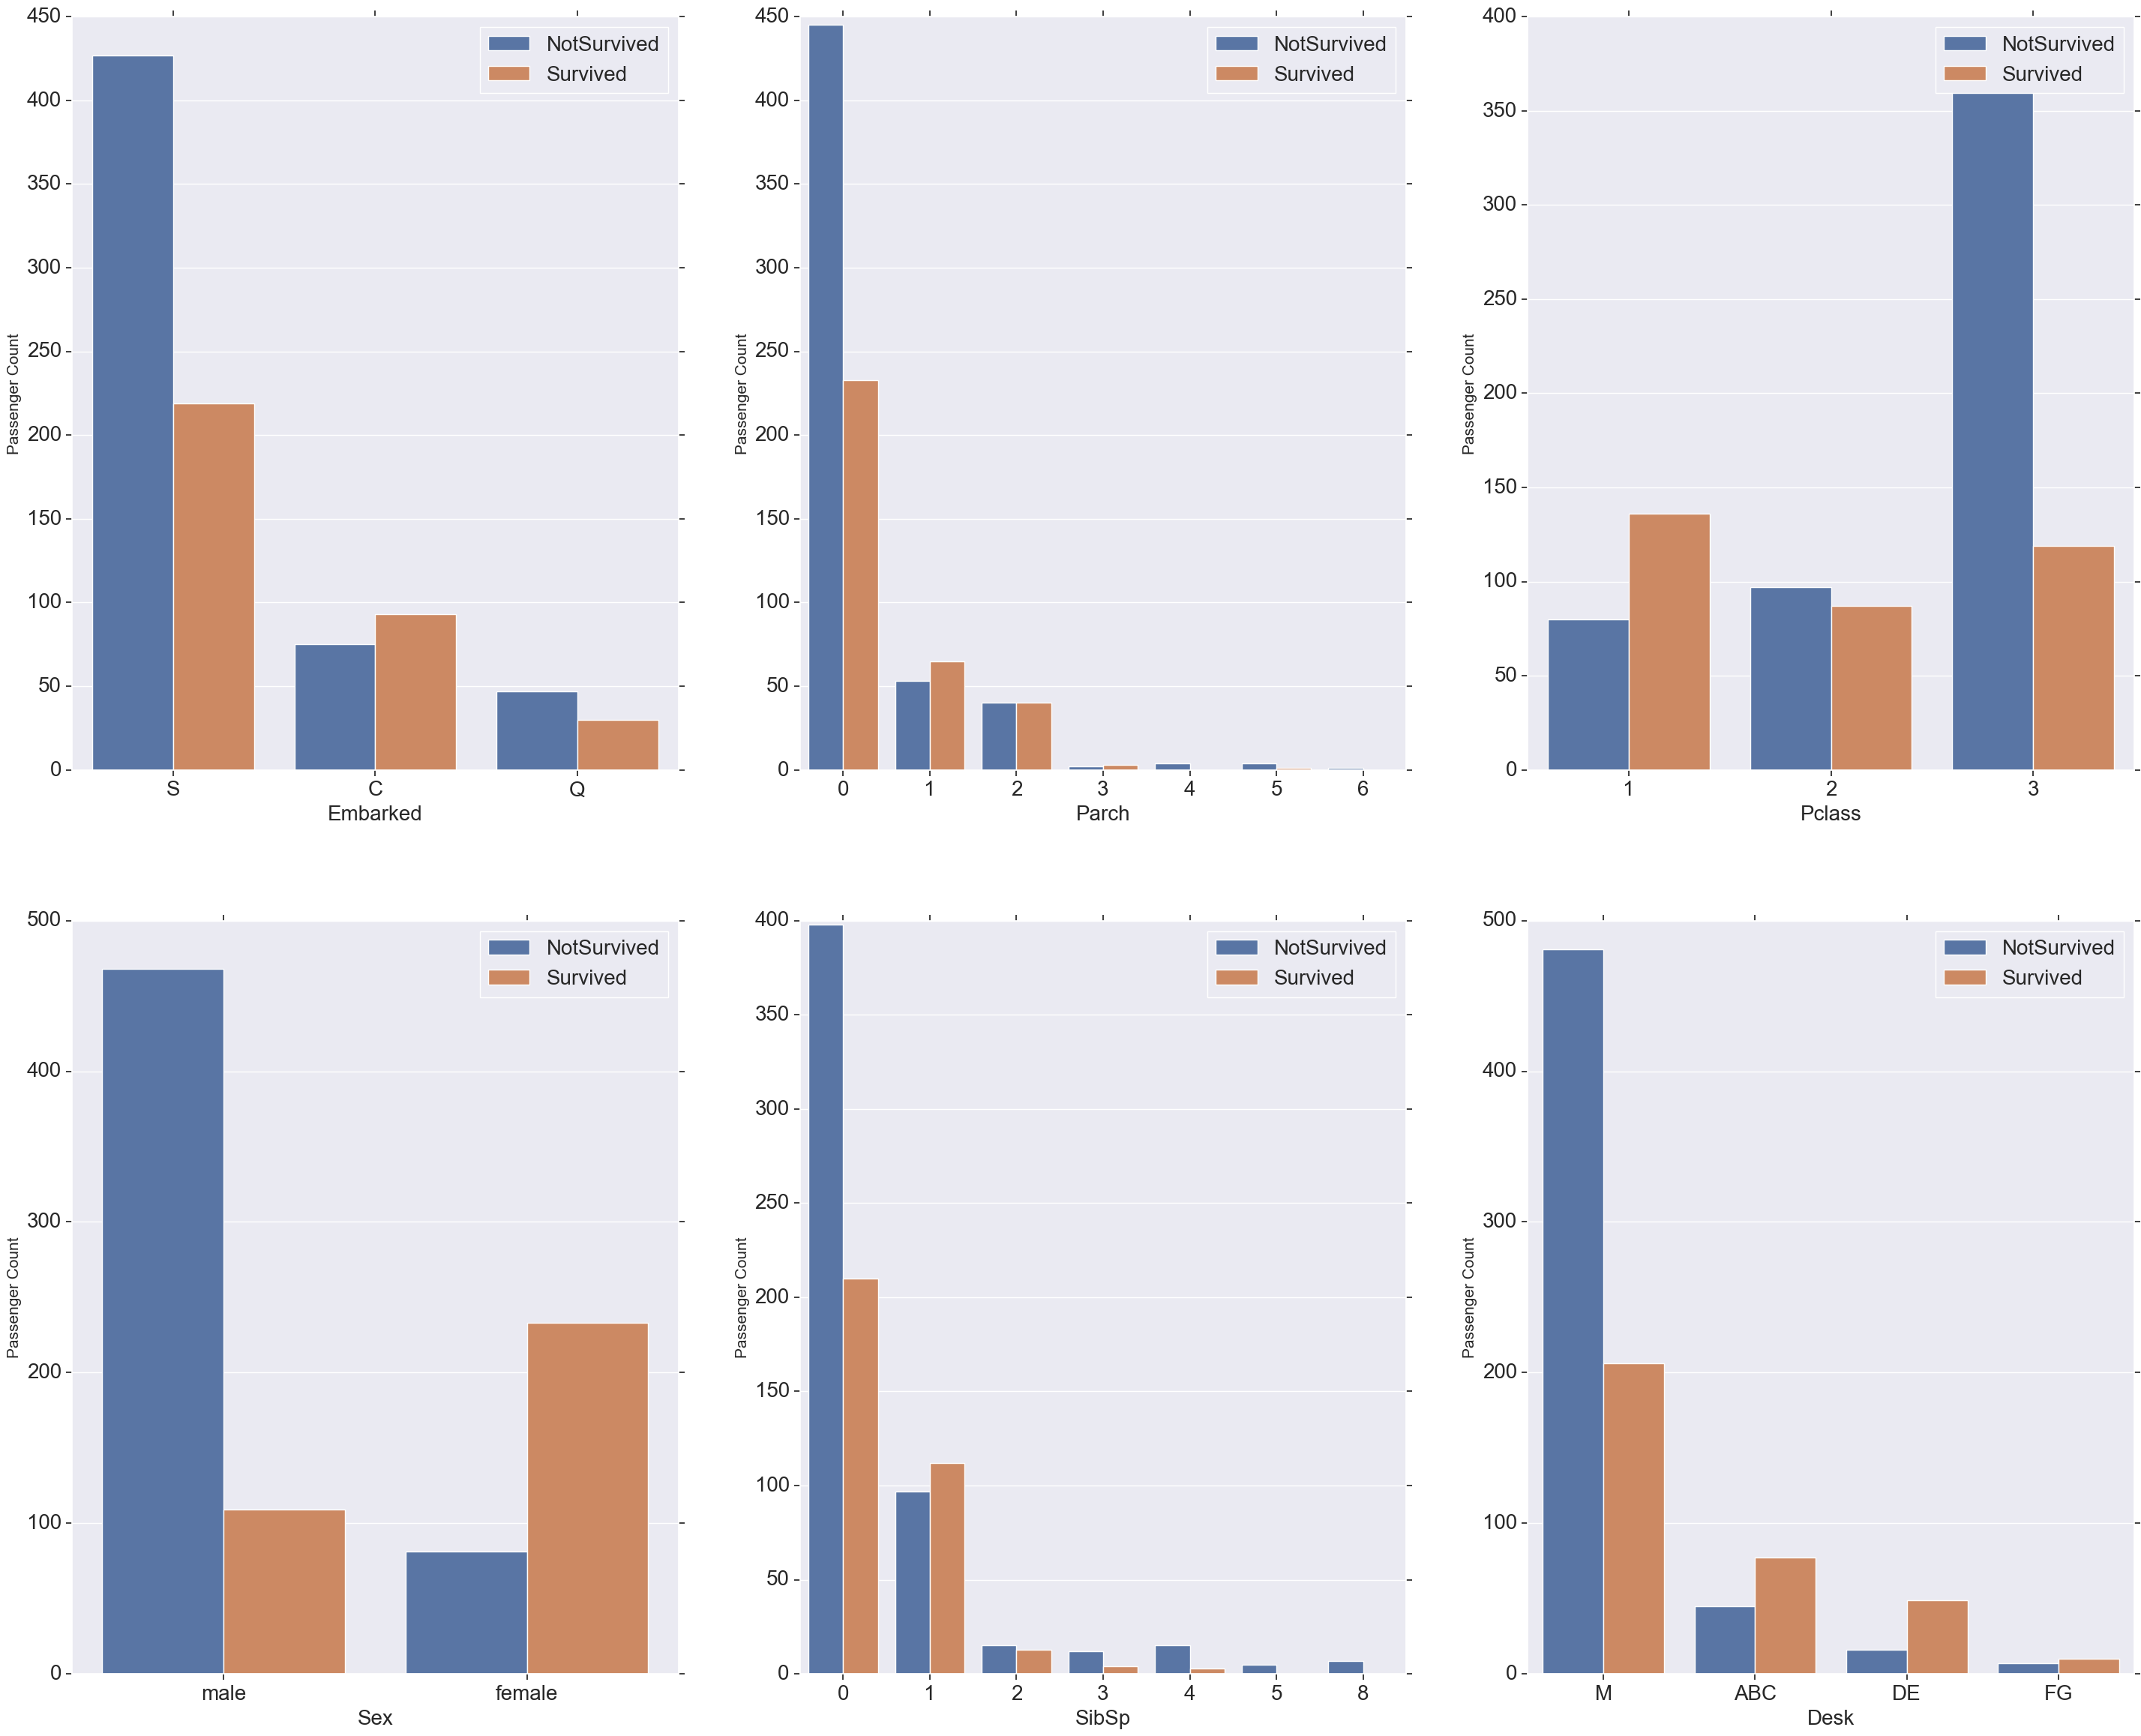

In [31]:
### 种类特征  - 或者叫离散特征
cat_features = ['Embarked','Parch','Pclass','Sex','SibSp','Desk']
fig,axis = plt.subplots(ncols = 2,nrows=3,figsize=(20,20))
plt.subplots_adjust(right = 1.5,top=1.23)

for i,feature in  enumerate(cat_features,1):
    plt.subplot(2,3,i)
    sns.countplot(x = feature,hue = 'Survived',data = df_train)
    plt.xlabel('{}'.format(feature),size= 20)
    plt.ylabel('Passenger Count',size =15)
    plt.tick_params(axis='x',labelsize = 20)
    plt.tick_params(axis='y',labelsize = 20)
    plt.legend(['NotSurvived','Survived'],prop={'size':20})
plt.show()

In [32]:
### 1.6 conclusion
df_all = concat_df(df_train,df_test)
df_all.head(3)

,Age,Desk,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282


## 2 特征工程

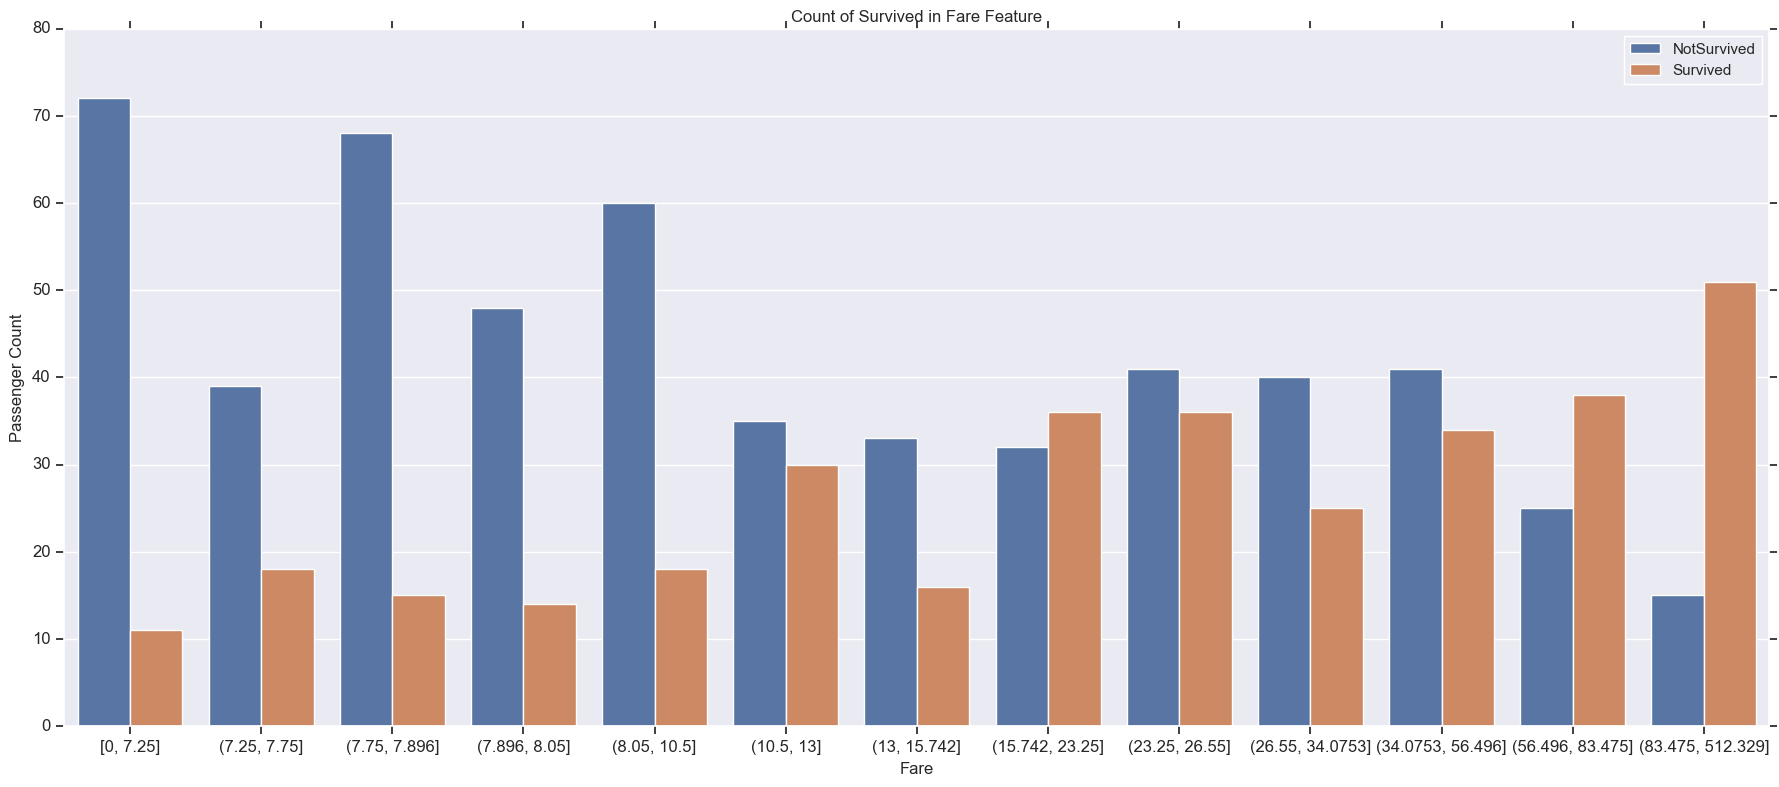

In [33]:
df_all['Fare'] = pd.qcut(df_all['Fare'],13)
#fig,axs        = plt.subplots(figsize = (22,9))
plt.figure(figsize=(22,9))
sns.countplot(x = 'Fare',hue = 'Survived',data = df_all)
plt.xlabel('Fare',size =12)
plt.ylabel('Passenger Count',size =12)
plt.tick_params(axis = 'x',labelsize =12)
plt.tick_params(axis ='y',labelsize =12)
plt.legend(['NotSurvived','Survived'])
plt.title('Count of Survived in Fare Feature')
plt.show()

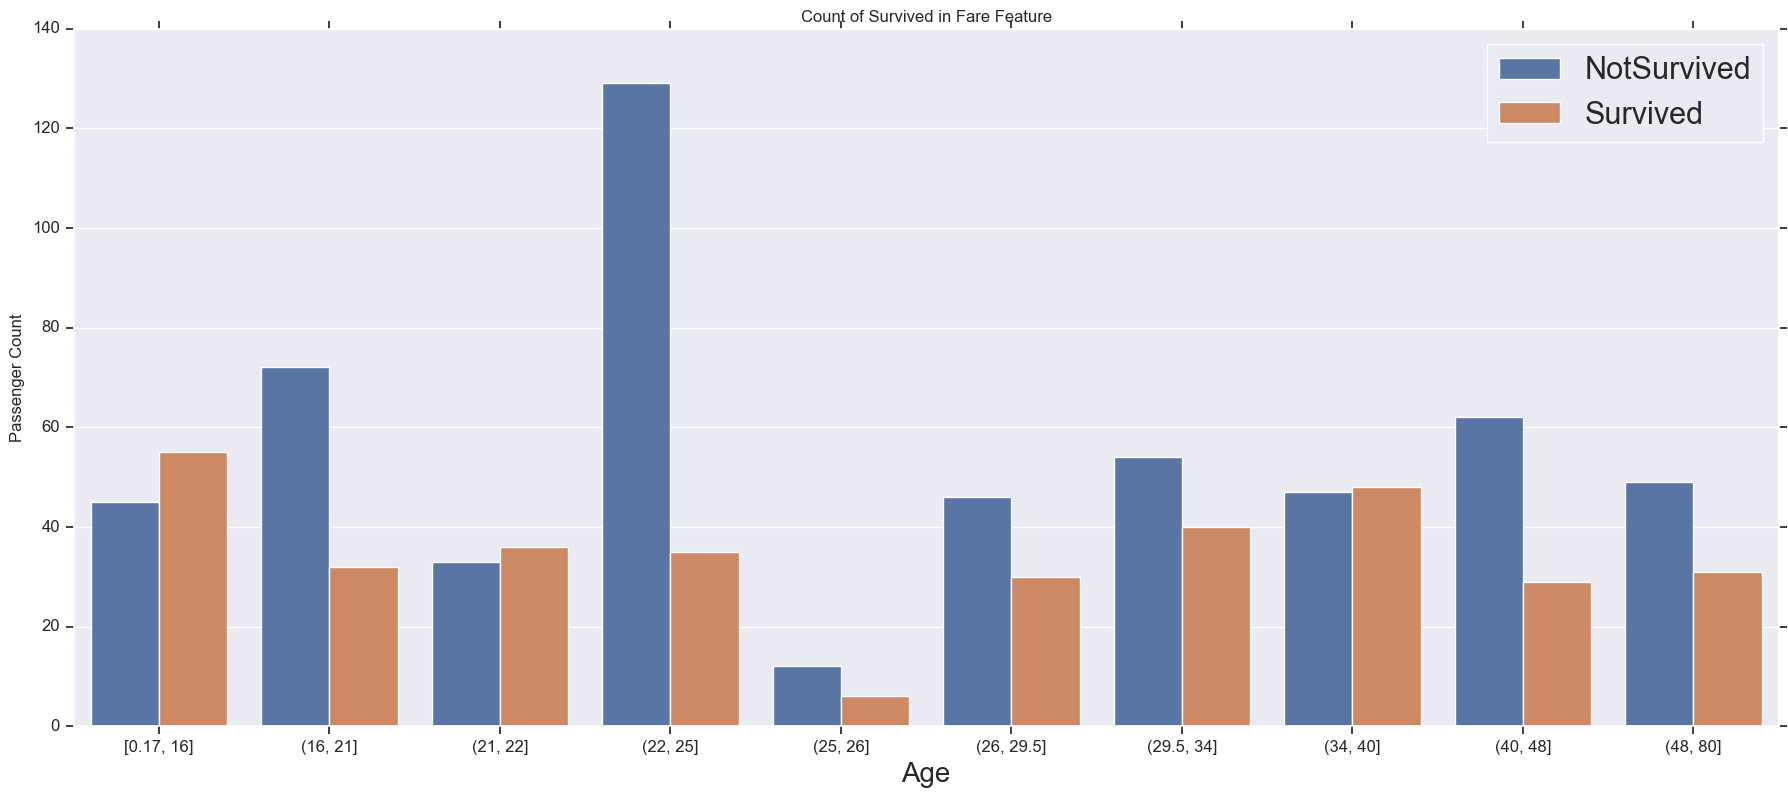

In [34]:
df_all['Age'] = pd.qcut(df_all['Age'],10)
plt.figure(figsize=(22,9))
sns.countplot(x = 'Age',hue = 'Survived',data = df_all)
plt.xlabel('Age',size =20)
plt.ylabel('Passenger Count',size =12)
plt.tick_params(axis = 'x',labelsize =12)
plt.tick_params(axis ='y',labelsize =12)
plt.legend(['NotSurvived','Survived'],prop={'size':22})
plt.title('Count of Survived in Fare Feature')
plt.show()

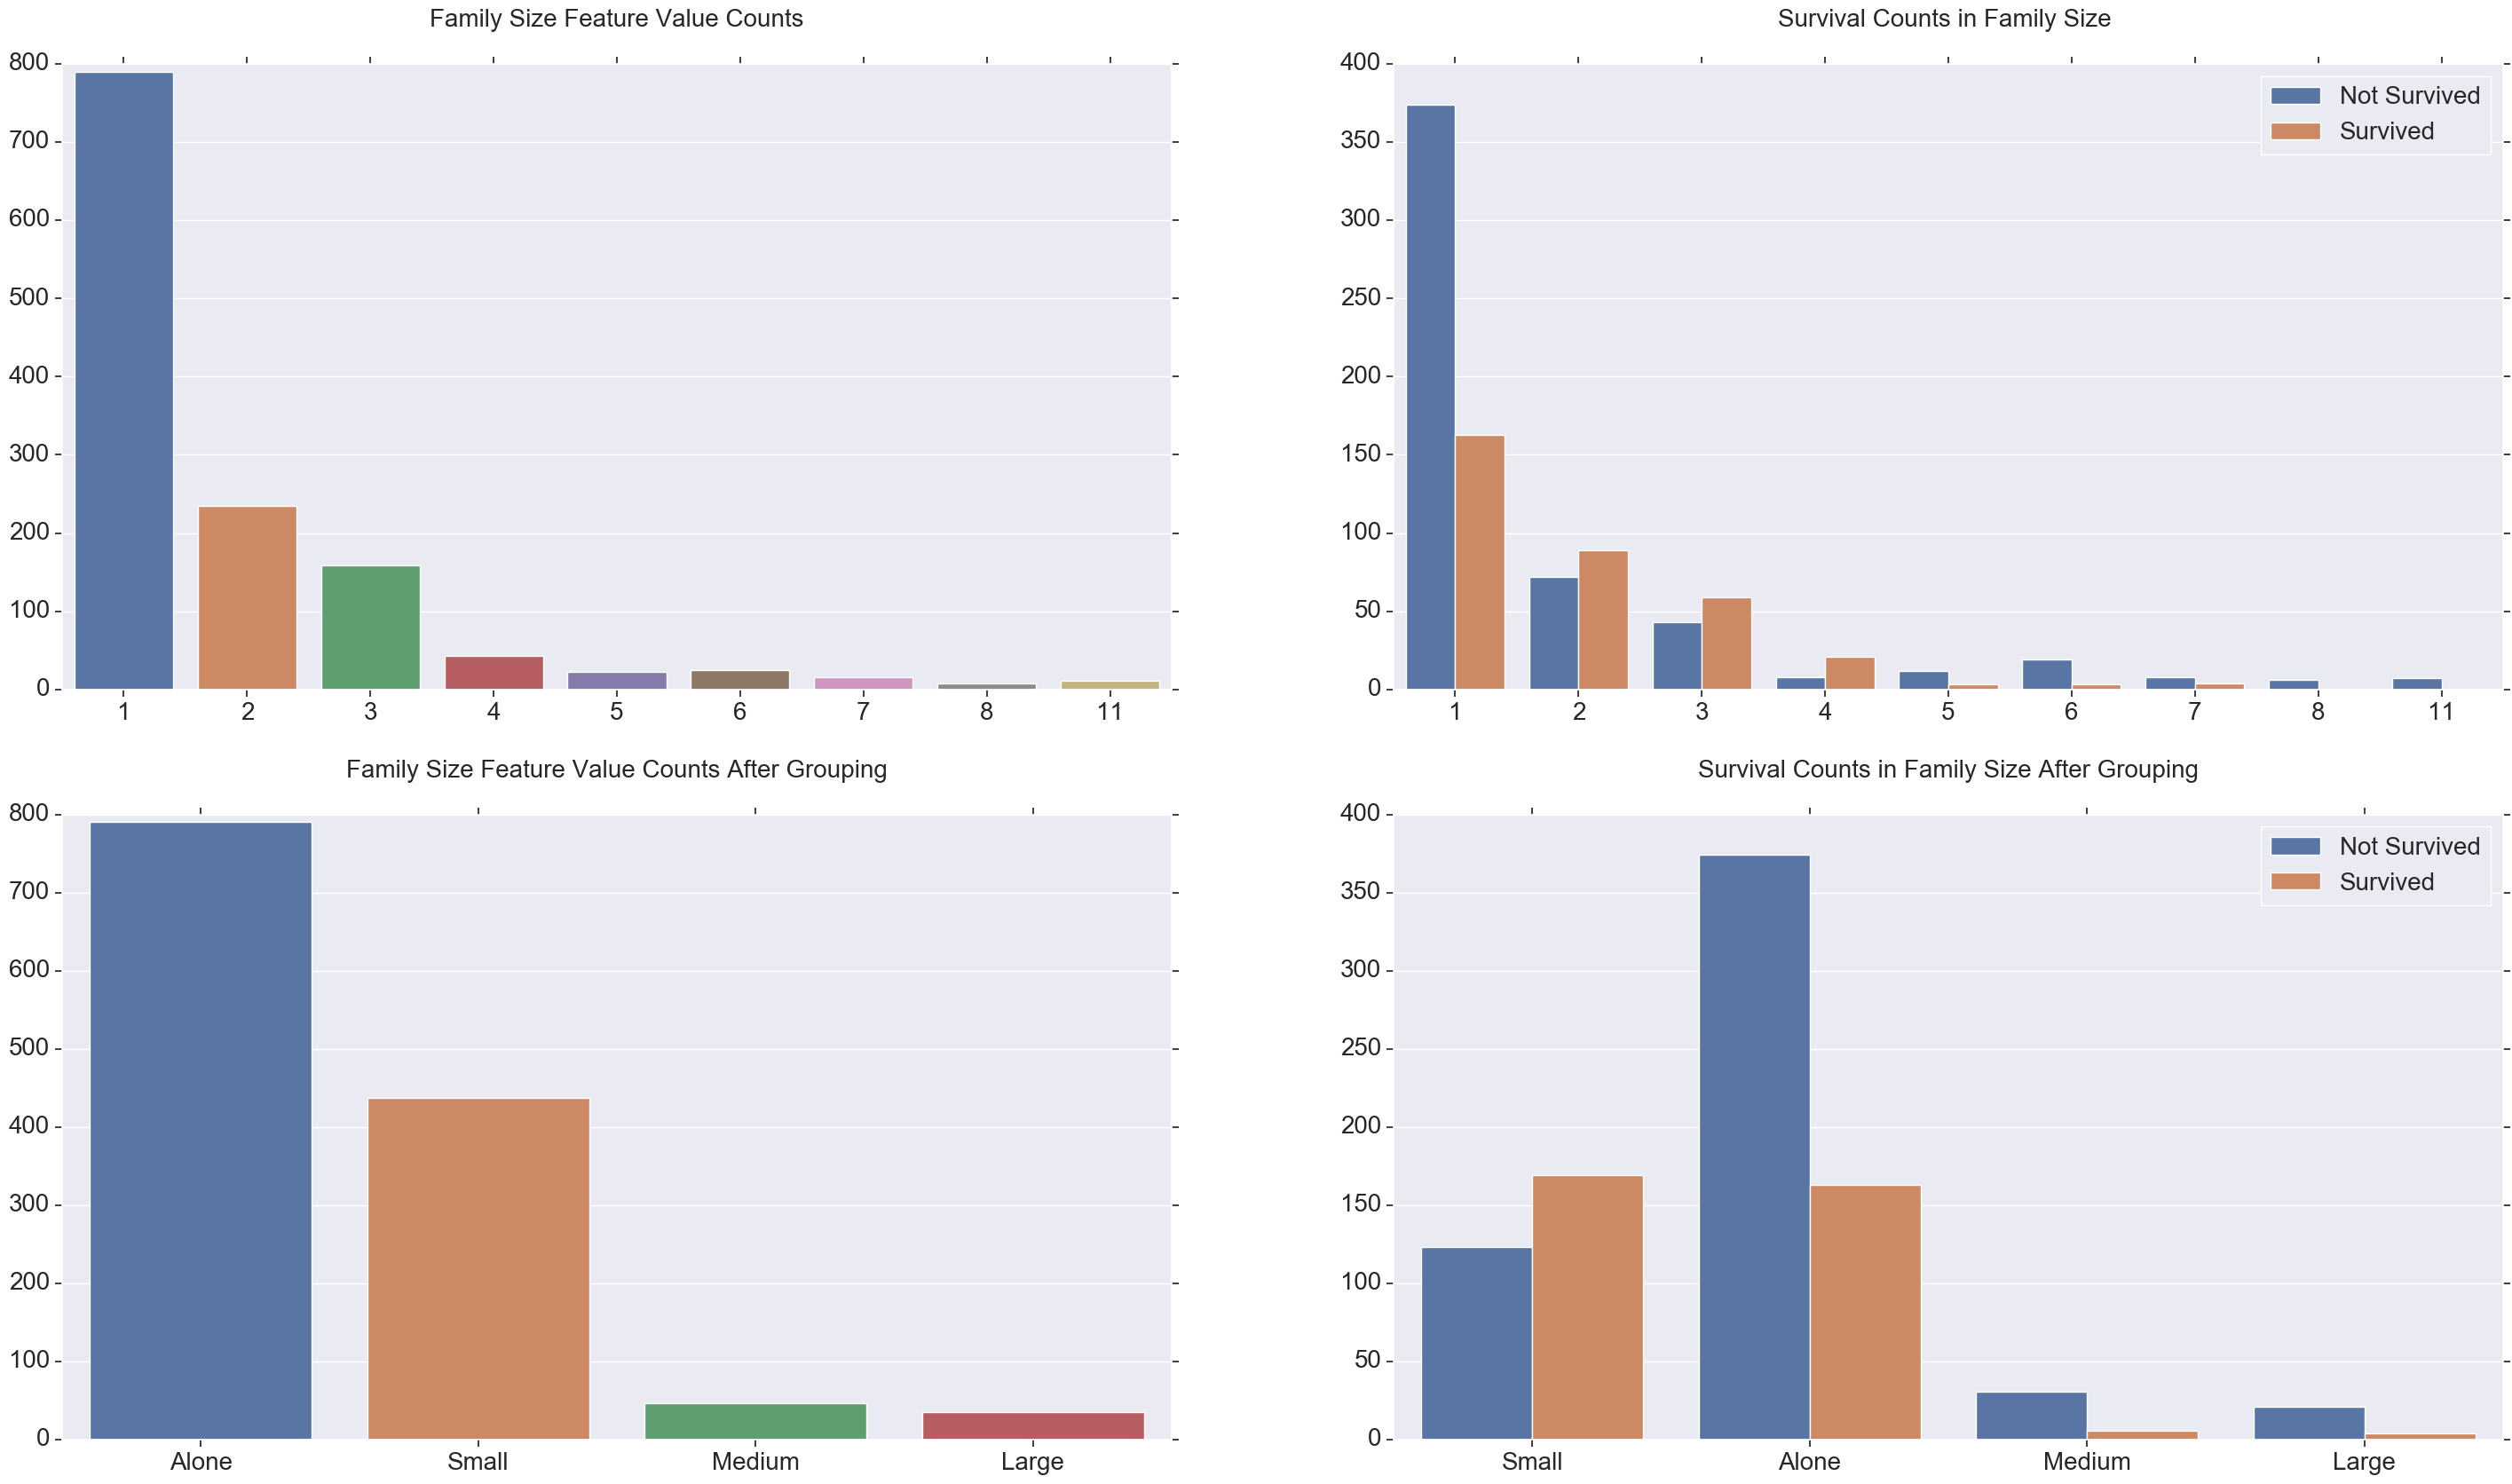

In [35]:
## 关于Family_Size的 数据挖掘
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')
plt.show()

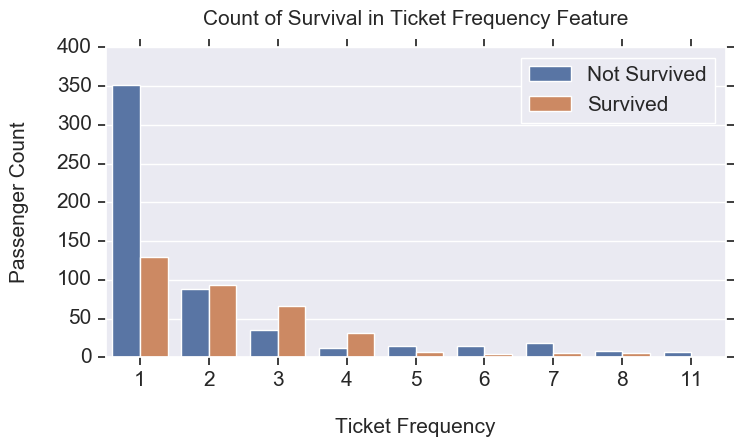

In [36]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

fig, axs = plt.subplots(figsize=(8, 4))
sns.countplot(x='Ticket_Frequency', hue='Survived', data = df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

In [37]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0] # 抽取首title
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

In [38]:
df_all['Title'][:4]

0      Mr
1     Mrs
2    Miss
3     Mrs
Name: Title, dtype: object

In [39]:
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')

In [40]:
df_all['Title'][:4]

0             Mr
1    Miss/Mrs/Ms
2    Miss/Mrs/Ms
3    Miss/Mrs/Ms
Name: Title, dtype: object

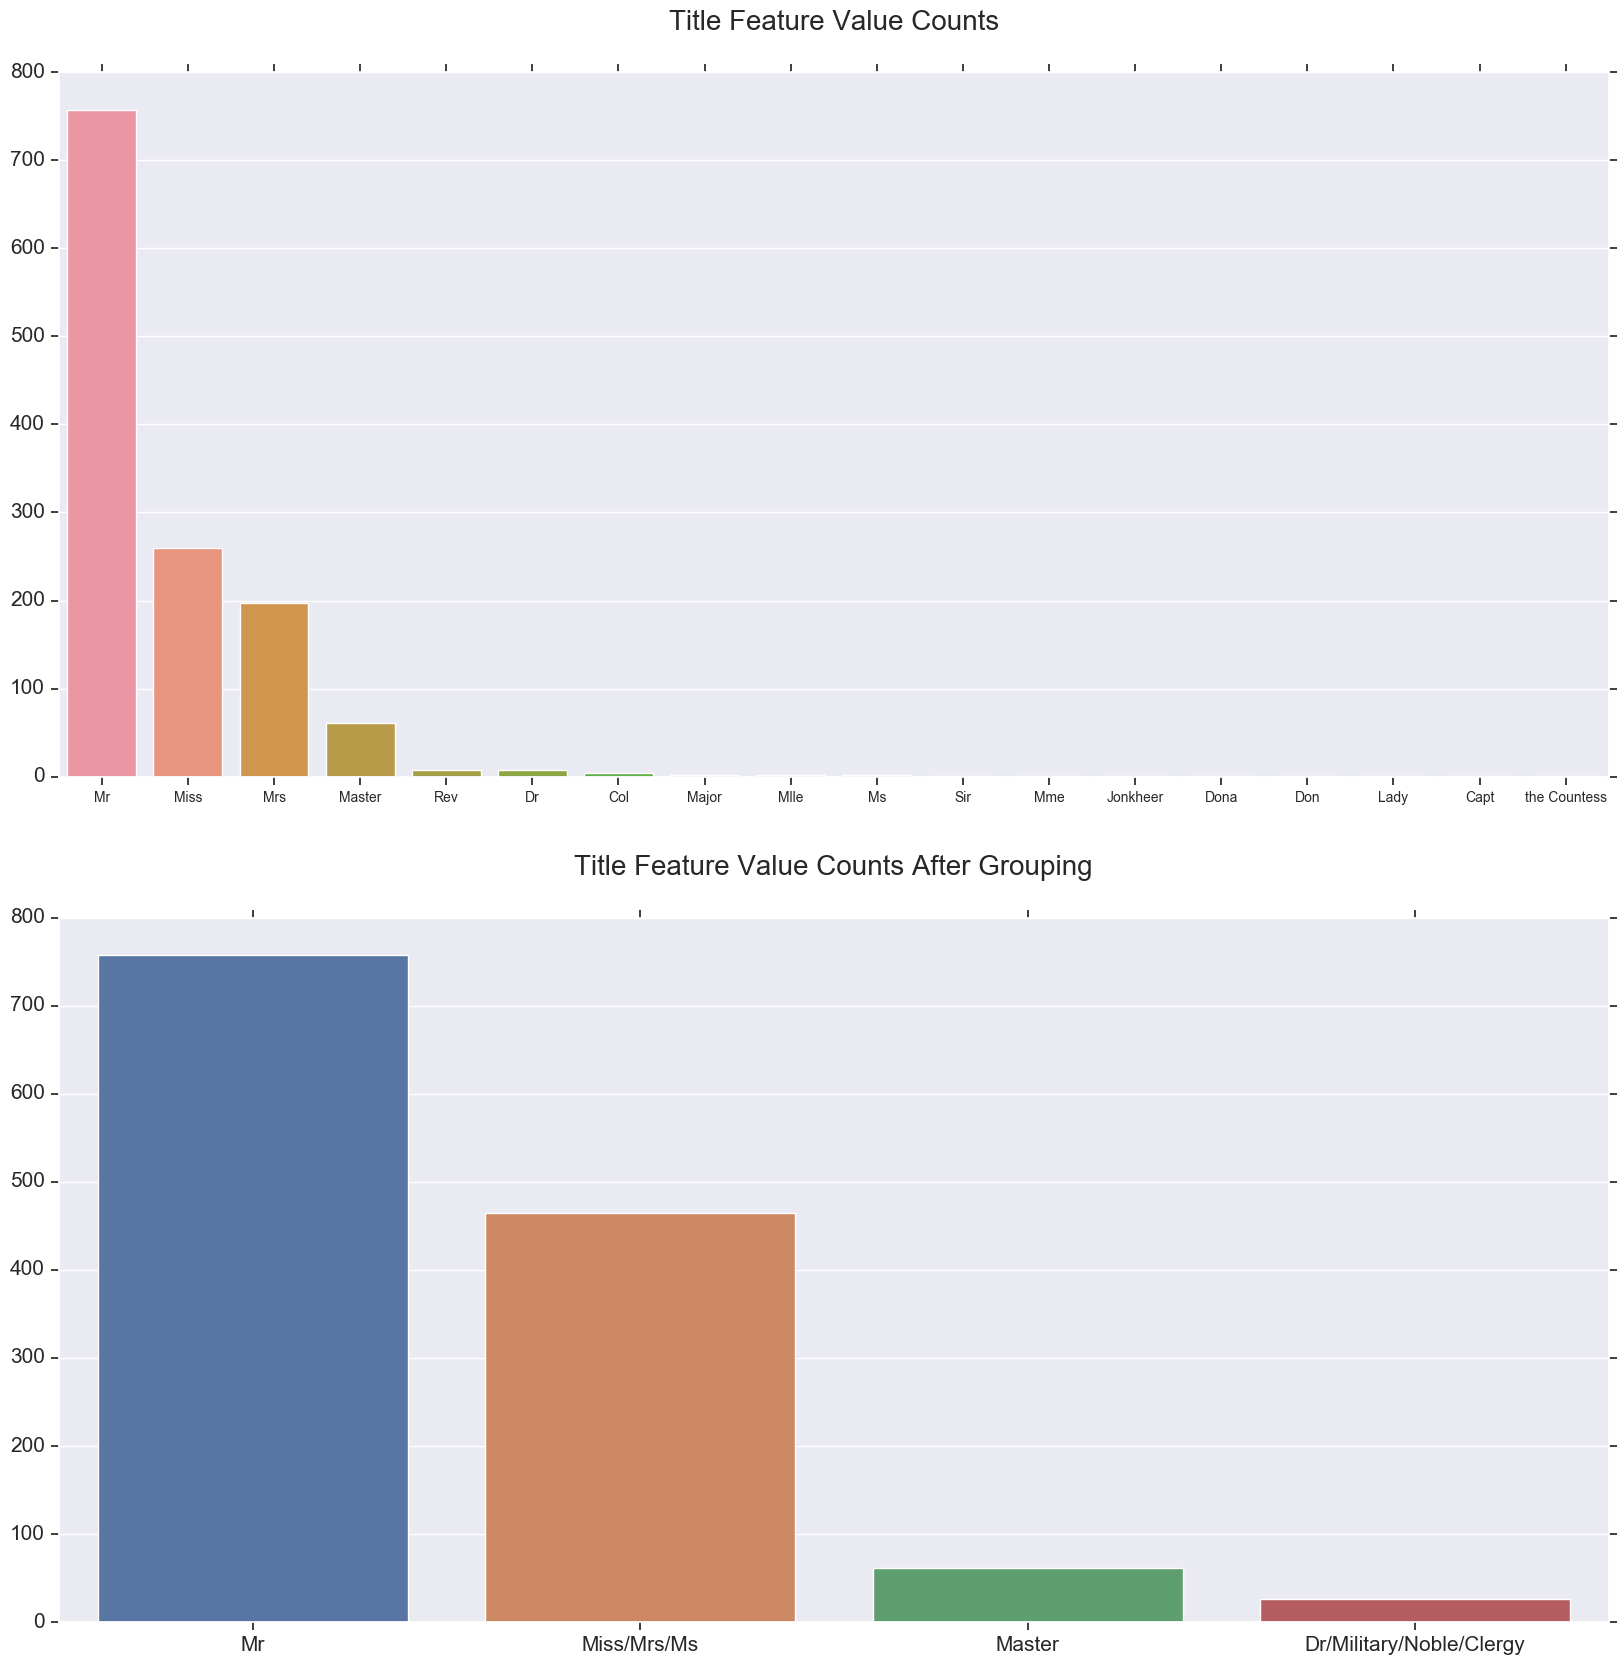

In [41]:
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

In [42]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

In [43]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [44]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

In [45]:
for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

In [46]:
non_numeric_features = ['Embarked', 'Sex', 'Desk', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [47]:
cat_features = ['Pclass', 'Sex', 'Desk', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [48]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Desk', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(drop_cols,axis = 1,inplace=True)

df_all.head()

,Age,Fare,Ticket_Frequency,Is_Married,Survival_Rate,Survival_Rate_NA,Pclass_1,Pclass_2,Pclass_3,Sex_1,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,1,12,1,0,0.383838,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,6,6,2,1,1.000000,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3,9,1,0,0.383838,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,6,5,2,1,0.383838,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,6,9,1,0,0.383838,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [49]:
X_train = StandardScaler().fit_transform(df_train.drop(drop_cols,axis=1))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(drop_cols,axis=1))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


In [50]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

In [51]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   

Fold 1 OOB Score: 0.848314606741573

Fold 2



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   

Fold 2 OOB Score: 0.8412921348314607

Fold 3



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   

Fold 3 OOB Score: 0.8387096774193549

Fold 4



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   

Fold 4 OOB Score: 0.8415147265077139

Fold 5



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   

Fold 5 OOB Score: 0.8515406162464986

Average OOB Score: 0.8442743523493201


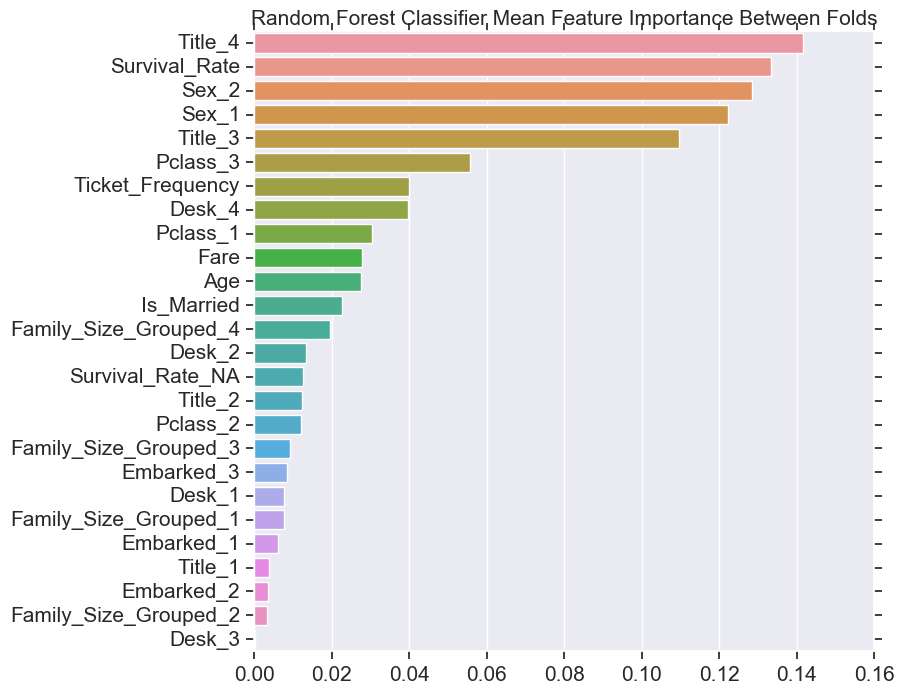

In [52]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(8, 8))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

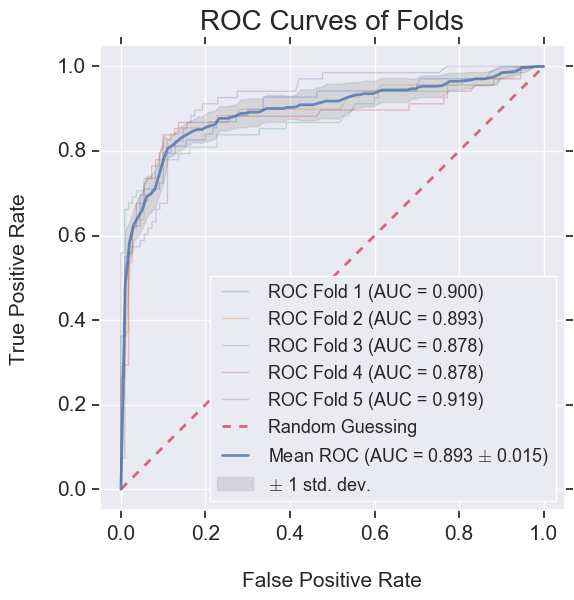

In [53]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(6, 6))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

In [55]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(class_survived,axis=1).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

In [56]:
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0
